# AutoEncoder

Reference: [Deep-Learning-TensorFlow](https://github.com/blackecho/Deep-Learning-TensorFlow) / [TensorFlow-Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

### Import

In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import os

from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
from config import Config
import utilities
import tf_utils


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Loss Function Class

In [2]:
class Loss(object):
   
   def __init__(self, loss_func, summary=True, name='loss'):
       self.loss_func = loss_func
       self.summary = summary
       self.name = name

   def compile(self, model_y, _y, regterm = None):
       with tf.name_scope(self.name):
           if self.loss_func == 'cross_entropy':
               clip_inf = tf.clip_by_value(model_y, 1e-10, float('inf'))
               clip_sup = tf.clip_by_value(1 - model_y,1e-10,float('inf'))

               cost = - tf.reduce_mean(_y * tf.log(clip_inf) +
                                       (1. - _y) * tf.log(clip_sup))
               
           elif self.loss_func == 'softmax_cross_entropy':
              cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_y, logits=model_y))
           elif self.loss_func == 'mean_squared':
              cost = tf.reduce_mean(tf.square(_y-model_y))
           else:
              cost = None

       if cost is not None:
           cost = cost + regterm if regterm is not None else cost
           tf.summary.scalar(self.loss_func,cost)
       else:
          cost = None

       return cost

### Optimizer Wrapper

In [3]:
class Trainer(object):
   def __init__(self, optimizer, **kw):
       assert optimizer in ["sgd","adagrad","adam","rmsprop"]

       def d(k, other=None):
           if other:
                return kw[k] if k in kw else other
           else:
                return kw[k]

       if optimizer == "sgd":
           self.opt_ = tf.train.GradientDescentOptimizer(d("learning_rate"))
       elif optimizer == "adagrad":
           self.opt_ = tf.train.AdagradOptimizer(d("learning_rate"), 
                                             d("initial_accumulator_value",0.1))
       elif optimizer == "adam":
           self.opt_ = tf.train.AdamOptimizer(d("learning_rate"),
                                                  d("beta1",0.7),
                                                  d("beta2",0.9),
                                                  d("epsilon",1e-08))
       elif optimizer == "rmsprop":
           self.opt_ = tf.train.RMSPropOptimizer(d("learning_rate"))

   def compile(self,cost, name_scope="train"):
       with tf.name_scope(name_scope):
           return self.opt_.minimize(cost)
                


### Hidden Layer Compute

In [4]:
class Layers(object):
   
   @staticmethod
   def logits(prev_layer, out_dim, name="logits"):
       
       with tf.name_scope(name):
           in_dim = prev_layer.get_shape()[1].value
           W = tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev =0.1))
           b = tf.Variable(tf.constant(0.1, shape = [out_dim]))
           out = tf.add(tf.matmul(prev_layer, W), b)
           return (out, W, b)
   
   @staticmethod
   def regularization(variables, regtype, regcoef, name="regularization"):
       
       with tf.name_scope(name):
           if regtype != 'none':
               regs = tf.constants(0.0)
               for v in variables:
                   if regtype == 'l2':
                        regs = tf.add(regs,tf.nn.l2_loss(v))
                   elif regtype == 'l1':
                        regs = tf.add(regs, tf.reduce_sum(tf.abs(v)))

               return tf.mul(regcoef, regs)
           else:
               return None

### Evaluation Function



In [5]:
class Evaluation(object):
   
   @staticmethod
   def accuracy(model_y, _y, summary = True, name="accuracy"):
       with tf.name_scope(name):
           model_predict_class = tf.argmax(model_y,1)
           correct_predict = tf.equal(model_predict_class, tf.argmax(_y, 1))
           accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))

           if summary:
               tf.summary.scalar('accuracy', accuracy)
           return accuracy
   
   @staticmethod
   def error(model_y, _y, summary = True, name="error"):
       with tf.name_scope(name):
           model_predict_class = tf.argmax(model_y,1)
           error_predict = tf.not_equal(model_predict_class, tf.argmax(_y, 1))
           error = tf.reduce_mean(tf.cast(error_predict, tf.float32))

           if summary:
               tf.summary.scalar('error', error)
           return error


### Early-Stop Class

In [6]:
class EarlyStopping(object):

   def __init__(
       self, min_delta = 0, patience = 0 ,mode='min',
       saver = None, session = None, path = None):
       
       self.patience = patience
       self.min_delta = min_delta
       self.wait = 0
       self.stopped_epoch = 0
       self.stop_training = False
       self.update = True
       self.saver = saver
       self.session = session
       self.path = path

       if mode not in ['min' , 'max']:
           raise Exception("EarlyStopping mode %s is unknown" % self.mode)
       
       if mode == 'min':
           self.monitor_op = np.less
       else:
           self.monitor_op = np.greater

       if self.monitor_op == np.greater:
           self.min_delta *= 1
       else:
           self.min_delta *= -1

   def on_train_begin(self):
       self.wait = 0
       self.best = np.Inf if self.monitor_op == np.less else -np.Inf

   def on_epoch_end(self, epoch, current):
           
       if self.monitor_op(current - self.min_delta, self.best):
           if self.update:
               self.best = current
               self.stopped_epoch = epoch
               self.wait = 0
               self.saver.save(self.session, self.path)
       else:
           if self.wait >= self.patience:
               self.stop_training = True
           self.wait += 1
       return self.stop_training

   def on_train_end(self):
       if self.stopped_epoch > 0:
          self.saver.restore(self.session, self.path)
          print('Epoch %05d: early stopping' % (self.stopped_epoch))

## DenoisingAutoencoder

In [7]:
class DenoisingAutoencoder(object):
   
   def __init__(
       self, n_components, name='dae',
       encoding_func = tf.nn.sigmoid, decoding_func = tf.nn.sigmoid,
       loss_func = 'mean_squared', num_epochs = 10, batch_size =256,
       opt = 'rmsprop', learning_rate = 0.01,
       corruption_type = 'none', corruption_level = 0.0,
       regtype='none', regcoef=5e-4,
       min_delta=0.0 ,patience=0 ,mode='min'
       ):

       self.name = name
       self.model_path = os.path.join(Config().models_dir, self.name)

       self.input_labels = None
       self.keep_prob = None
       self.layer_nodes = []
       self.train_step = None
       self.cost = None

       # Init tensorflow objects
       self.tf_graph = tf.Graph()
       self.tf_session = None
       self.tf_saver = None
       self.tf_merged_summaries = None
       self.tf_summary_writer = None

       # Init training parameters
       self.loss_func = loss_func
       self.learning_rate = learning_rate
       self.dropout = 1 
       self.num_epochs = num_epochs
       self.batch_size = batch_size
       self.opt = opt
       self.regtype = regtype
       self.regcoef = regcoef


       self.loss = Loss(self.loss_func)
       self.trainer = Trainer(opt,learning_rate = learning_rate)

       self.n_components = n_components
       self.encoding_func = encoding_func
       self.decoding_func = decoding_func

       self.corruption_type = corruption_type
       self.corruption_level = corruption_level
    
       self.min_delta = min_delta
       self.patience = patience
       self.mode = mode

   
    
       self.input_data_orig = None
       self.input_data = None

       self.W = None
       self.b_hidden_ = None
       self.b_visible_ = None


   def _create_placeholders(self, n_features):
       
       self.input_data_orig = tf.placeholder(tf.float32, 
                                             [None, n_features], name='x-input')
       self.input_data= tf.placeholder(tf.float32, 
                                       [None, n_features], name='x-corr-input')

       self.input_labels = tf.placeholder(tf.float32)
       self.keep_prob = tf.placeholder(tf.float32 , name='keep-probs')
       
   def _create_variables(self, n_features, W_=None , b_hidden_ = None, b_visible_=None):
       
       if W_:
           self.W_ = tf.Variable(W_ , name = 'encoding_w')
       else:
           self.W_ = tf.Variable(
               tf.truncated_normal(
                   shape=[n_features, self.n_components], stddev=0.1,
                   name = 'encoding_w'))

       if b_hidden_:
           self.b_hidden_ = tf.Variable(b_hidden_, name='hidden-bias')
       else:
           self.b_hidden_ = tf.Variable(tf.constant(
                0.1, shape=[self.n_components]), name='hidden-bias')
      
       if b_visible_:
           self.b_visible_ = tf.Variable(b_visible_, name='visible-bias')
       else:
           self.b_visible_ = tf.Variable(tf.constant(
               0.1, shape=[n_features]), name='visible-bias')

   def _create_encode_layer(self):
        
       with tf.name_scope("encoder"):

           activation = tf.add(
               tf.matmul(self.input_data, self.W_),
               self.b_hidden_
           )

           if self.encoding_func:
               self.encode = self.encoding_func(activation)
           else:
               self.encode = activation

   def _create_decode_layer(self):
        
       with tf.name_scope("decoder"):

           activation = tf.add(
               tf.matmul(self.encode, tf.transpose(self.W_)),
               self.b_visible_
           )

           

           if self.decoding_func:
               self.reconstruction = self.decoding_func(activation)
           else:
               self.reconstruction = activation
        
        
   def fit(self, train_X, train_Y = None, val_X = None, val_Y=None, graph=None):

       g = graph if graph is not None else self.tf_graph


       with g.as_default():
           # Build Model
           self.build_model(train_X.shape[1])
           with tf.Session() as self.tf_session:
               # Init tf stuff
               summary_objs = tf_utils.init_tf_ops(self.tf_session)
               self.tf_merged_summaries = summary_objs[0]
               self.tf_summary_writer = summary_objs[1]
               self.tf_saver = summary_objs[2]
               self.earlystop = EarlyStopping(self.min_delta , self.patience, self.mode, 
                                              self.tf_saver, self.tf_session, self.model_path)
               # Train model
               self._train_model(train_X, train_Y, val_X, val_Y)

               # Save model
               self.tf_saver.save(self.tf_session, self.model_path)

   def build_model(self, n_features, W_= None, b_hidden_=None , b_visible_=None):

       self._create_placeholders(n_features)
       self._create_variables(n_features, W_, b_hidden_ , b_visible_)

       self._create_encode_layer()
       self._create_decode_layer()

       variables = [self.W_ , self.b_hidden_ , self.b_visible_]
       regterm = Layers.regularization(variables, self.regtype, self.regcoef)

       self.cost = self.loss.compile(self.reconstruction, self.input_data_orig,regterm=regterm)

       self.train_step = self.trainer.compile(self.cost)

   def _train_model(self, train_set, train_ref = None,
                    validation_set = None, validation_ref = None):
       pbar = tqdm(range(self.num_epochs))
       train = [0]
       valid = [0]
       
       self.earlystop.on_train_begin()

       for i in pbar:
           train_loss = self._run_train_step(train_set)
           
           if validation_set is not None:
               feed = {self.input_data_orig: validation_set,
                       self.input_data: validation_set}
               tr_feed = {self.input_data_orig: train_set,
                          self.input_data: train_set}
               valid_loss = tf_utils.run_summaries(
                   self.tf_session, self.tf_merged_summaries,
                   self.tf_summary_writer, i, feed, self.cost)
         
               pbar.set_description("Epoch %02d/%02d"% (i+1,self.num_epochs))
               

               print ("Epoch %02d/%02d, Train Loss: %.9f, Validation Loss: %.9f, Best: %.9f, Wait: %02d"  
                           % (i+1, self.num_epochs,train_loss,valid_loss,self.earlystop.best,self.earlystop.wait))
               train.append(train_loss)
               valid.append(valid_loss)
               if (self.earlystop.on_epoch_end(i+1,valid_loss)):
                   self.earlystop.update = False
                   break
       self.earlystop.on_train_end()

       plt.plot(train[:], label='train')
       plt.plot(valid[:], label='validation')
       plt.axvline(x=self.earlystop.stopped_epoch, color='r')
       plt.plot(self.earlystop.stopped_epoch, valid[self.earlystop.stopped_epoch],'ro')
       axes = plt.gca()
       #ymajorLocator   = MultipleLocator(0.001)   
       #ymajorFormatter = FormatStrFormatter('%1.4f')   
       #yminorLocator   = MultipleLocator(0.0005)   
       #axes.yaxis.set_major_locator(ymajorLocator)  
       #axes.yaxis.set_major_formatter(ymajorFormatter)  
       #axes.yaxis.set_minor_locator(yminorLocator)  
       axes.set_xlim(1)
       plt.grid()
       plt.xlabel("Epochs")
       plt.ylabel("MSE")
       #plt.yscale('log', nonposy='clip')
       plt.title("Training Curve")
       plt.legend(loc='best')
       plt.annotate('Stop Here (%d , %.6f)' % (self.earlystop.stopped_epoch, valid[self.earlystop.stopped_epoch]), 
                   xy=(self.earlystop.stopped_epoch, valid[self.earlystop.stopped_epoch]), xycoords='data',
                   textcoords='offset points', xytext=(+10,+30), fontsize = 20,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
       plt.show()

   def _run_train_step(self, train_set):
       
       x_corrupted = utilities.corrupt_input(
           train_set, self.tf_session, 
           self.corruption_type, self.corruption_level)

       shuff = list(zip(train_set, x_corrupted))
       np.random.shuffle(shuff)

       batches = [_ for _ in utilities.gen_batches(shuff, self.batch_size)]
       cost = []
       for batch in batches:
           x_batch, x_corr_batch = zip(*batch)
           train_feed = {self.input_data_orig: x_batch,
                      self.input_data: x_corr_batch}
           self.tf_session.run(self.train_step, feed_dict = train_feed)
           train_cost = self.tf_session.run(self.cost,feed_dict = train_feed)
           cost.append(train_cost)
       cost_mean = np.mean(cost, dtype='float64')
       return cost_mean
                
                
            
   def transform(self, data, graph = None):
       
       g = graph if graph is not None else self.tf_graph
       with g.as_default():
           with tf.Session() as self.tf_session:
               self.tf_saver.restore(self.tf_session, self.model_path)
               feed = {
                   self.input_data : data,
                   self.keep_prob: 1
               }
               return self.encode.eval(feed)
           
   def reconstruct(self, data, graph = None):
       
       g = graph if graph is not None else self.tf_graph
       with g.as_default():
           with tf.Session() as self.tf_session:
               self.tf_saver.restore(self.tf_session, self.model_path)
               feed = {
                   self.input_data : data,
                   self.keep_prob: 1
               }
               return self.reconstruct.eval(feed)

   
   def score(self, data, data_ref, graph = None):
       
       g = graph if graph is not None else self.tf_graph
       with g.as_default():
           with tf.Session() as self.tf_session:
               self.tf_saver.restore(self.tf_session, self.model_path)
               feed = {
                   self.input_data : data,
                   self.input_labels : data_ref,
                   self.keep_prob: 1
               }
               return self.cost.eval(feed)
   


   def get_parameters(self, graph=None):
       
       g = graph if graph is not None else self.tf_graph

       with g.as_default():
           with tf.Session() as self.tf_session:
               self.tf_saver.restore(self.tf_session, self.model_path)

               return {
                   'encoding_w': self.W_.eval(),
                   'encoding_b': self.b_hidden_.eval(),
                   'decoding_b': self.b_visible_.eval()
               }
   

### StackedDenoisingAutoencoder

In [8]:
class StackedDenoisingAutoencoder(object):
   

   def __init__(
       self, layers = [900,784,512,30], 
       name='sdae',
       encoding_func = [tf.nn.sigmoid],decoding_func = [tf.nn.sigmoid],
       loss_func=['mean_squared'], num_epochs=[50], batch_size=[256],
       opt=['adam'], learning_rate=[0.015,0.015,0.015], 
       regtype=['none'], regcoef=[5e-4],
       corruption_type=['masking','none','none','none'],corruption_level=[0.3],
       min_delta=[0.000001],patience=[10],mode=['min'],
       finetune_dropout=0.7, finetune_loss='softmax_cross_entropy',
       finetune_func=tf.nn.sigmoid, finetune_opt='adam',
       finetune_learning_rate = 0.03, finetune_num_epochs = 100, 
       finetune_batch_size=256, do_pretrain = False):

       # Expand all list parameters to be length of layers
       expanded_args = utilities.expand_args(**locals())

       
       self.name = name
       self.model_path = os.path.join(Config().models_dir, self.name)

       self.input_data = None
       self.input_labels = None
       self.keep_prob = None
       self.layer_nodes = []
       self.train_step = None
       self.cost = None


       # Init tensorflow objects
       self.tf_graph = tf.Graph()
       self.tf_session = None
       self.tf_saver = None
       self.tf_merged_summaries = None
       self.tf_summary_writer = None

       # Init training parameters
       self.loss_func = finetune_loss
       self.learning_rate = finetune_learning_rate
       self.dropout = finetune_dropout
       self.num_epochs = finetune_num_epochs
       self.batch_size = finetune_batch_size
       self.opt = finetune_opt


       self.loss = Loss(self.loss_func)
       self.trainer = Trainer(finetune_opt, 
                              learning_rate=finetune_learning_rate)


       self.do_pretrain = do_pretrain
       self.layers = layers
       self.finetune_func = finetune_func
                                     
       
       self.encoding_w_ = []
       self.encoding_b_ = []

       self.last_W = None
       self.last_b = None

       self.autoencoders = []
       self.autoencoder_graphs =[]

       for l, layer in enumerate(layers):
           dae_str = 'Autoencoder Layer ' + str(l+1)
           self.autoencoders.append(
               DenoisingAutoencoder(
                 n_components = layer,
                 name = dae_str,
                 encoding_func = expanded_args['encoding_func'][l],
                 decoding_func = expanded_args['decoding_func'][l],
                 loss_func = expanded_args['loss_func'][l],
                 num_epochs = expanded_args['num_epochs'][l],
                 opt = expanded_args['opt'][l],
                 batch_size = expanded_args['batch_size'][l],
                 learning_rate = expanded_args['learning_rate'][l],
                 corruption_type = expanded_args['corruption_type'][l],
                 corruption_level = expanded_args['corruption_level'][l],
                 regtype = expanded_args['regtype'][l],
                 regcoef = expanded_args['regcoef'][l],
                 min_delta = expanded_args['min_delta'][l],
                 patience = expanded_args['patience'][l],
                 mode = expanded_args['mode'][l]))
           self.autoencoder_graphs.append(tf.Graph())

        
   def _create_placeholders(self, n_features, n_classes):
       self.input_data = tf.placeholder(tf.float32, [None, n_features] , name = 'x-input')
       self.input_labels = tf.placeholder(tf.float32, [None, n_classes], name = 'y-input')

       self.keep_prob = tf.placeholder(tf.float32, name='keep-probs')


   def _create_variables(self, n_features):
       if self.do_pretrain:
          self._create_variables_pretrain()
       else:
          self._create_variables_no_pretrain(n_features)


   def _create_variables_no_pretrain(self, n_features):
       
       for l, layer in enumerate(self.layers):
           
           if l==0:
               self.encoding_w_.append(tf.Variable(
                    tf.truncated_normal([n_features, self.layers[l]], stddev = 0.1)))
               self.encoding_b_.append(tf.Variable(
                    tf.constanst(0.1, [self.layers[l]])))
           else:
               self.encoding_w_.append(tf.Variable(
                    tf.truncated_normal([self.layers[l-1], self.layers[l]], stddev = 0.1)))
               self.encoding_b_.append(tf.Variable(
                    tf.constanst(0.1, [self.layers[l]])))

   def _create_variables_pretrain(self):
       
        for l, layer in enumerate(self.layers):
            self.encoding_w_[l] = tf.Variable(
                self.encoding_w_[l], name='enc-w-{}'.format(l))
            self.encoding_b_[l] = tf.Variable(
                self.encoding_b_[l], name='enc-b-{}'.format(l))

   def _create_encoding_layers(self):
        
       next_train = self.input_data
       self.layer_nodes = []

       for l, layer in enumerate(self.layers):

           with tf.name_scope("encode-{}".format(l)):
                
               y_act = tf.add(
                   tf.matmul(next_train, self.encoding_w_[l]),
                   self.encoding_b_[l]
               )
                
               if self.finetune_func:
                   layer_y = self.finetune_func(y_act)

               else:
                   layer_y = None

               # the input to the next layer is the output of this layer
               next_train = tf.nn.dropout(layer_y, self.keep_prob)

           self.layer_nodes.append(next_train)

       return next_train



   def fit(self, train_X, train_Y, val_X=None, val_Y=None, graph=None):

       if len(train_Y.shape)!= 1:
           num_classes = train_Y.shape[1]
       else:
           raise Exception("Please convert the labels with one-hot encoding")

       g = graph if graph is not None else self.tf_graph


       with g.as_default():
           # Build Model
           self.build_model(train_X.shape[1], num_classes)
           with tf.Session() as self.tf_session:
               # Init tf stuff
               summary_objs = tf_utils.init_tf_ops(self.tf_session)
               self.tf_merged_summaries = summary_objs[0]
               self.tf_summary_writer = summary_objs[1]
               self.tf_saver = summary_objs[2]

               # Train model
               self._train_model(train_X, train_Y, val_X, val_Y)

               # Save model
               self.tf_saver.save(self.tf_session, self.model_path)
   
   def build_model(self, n_features, n_classes):
       
       self._create_placeholders(n_features, n_classes)
       self._create_variables(n_features)

       next_train = self._create_encoding_layers()
       self.model_y, _, _ = Layers.logits(next_train, n_classes)
       self.layer_nodes.append(self.model_y)


       self.cost = self.loss.compile(self.model_y,self.input_labels)
       self.train_step = self.trainer.compile(self.cost)
       self.accuracy = Evaluation.accuracy(self.model_y, self.input_labels)
       self.error = Evaluation.error(self.model_y, self.input_labels)
   

   def _train_model(self, train_set, train_labels,
                    validation_set, validation_labels):

       shuff = list(zip(train_set, train_labels))
       shuff_v = list(zip(validation_set,validation_labels))
       pbar = tqdm(range(self.num_epochs))
       for i in pbar:
           np.random.shuffle(shuff)

           batches = [_ for _ in utilities.gen_batches(
               shuff, self.batch_size)]
                      
           for batch in batches:
               x_batch, y_batch = zip(*batch)
               feed = {self.input_data: x_batch,
                       self.input_labels: y_batch,
                       self.keep_prob: self.dropout}
               self.tf_session.run(self.train_step,feed_dict= feed)
           if validation_set is not None:
               feed = {self.input_data: validation_set,
                       self.input_labels: validation_labels,
                       self.keep_prob: 1}
               acc = tf_utils.run_summaries(
                   self.tf_session, self.tf_merged_summaries,
                   self.tf_summary_writer, i, feed, self.accuracy)
               pbar.set_description("Accuracy: %s" % (acc))


   
               
   def score(self, test_X, test_Y):
       
       with self.tf_graph.as_default():
           with tf.Session() as self.tf_session:
               self.tf_saver.restore(self.tf_session, self.model_path)
               feed = {
                   self.input_data : test_X,
                   self.input_labels : test_Y,
                   self.keep_prob: 1
               }
               return self.accuracy.eval(feed)
   
   def get_layers_output(self, dataset):
       
       layers_out =[]

       with self.tf_graph.as_default():
           with tf.Session() as self.tf_session:
               self.tf_saver.restore(self.tf_session, self.model_path)
               for l in self.layer_nodes:
                   layers_out.append(l.eval({self.input_data : dataset,
                                             self.keep_prob : 1}))

       if layers_out == []:
           raise Exception("This method is not implemented for this model")
       else:
           return layers_out


   def pretrain(self, train_set, validation_set=None):
       
       self.do_pretrain = True

       def set_params_func(autoenc, autoencgraph):
           params = autoenc.get_parameters(graph = autoencgraph)
           self.encoding_w_.append(params['encoding_w'])
           self.encoding_b_.append(params['encoding_b'])

       next_train = train_set
       next_valid = validation_set
       layer_objs = self.autoencoders
       layer_graphs = self.autoencoder_graphs
       
       
    
       for l, layer_obj in enumerate(layer_objs):
          print('Training layer {}...'.format(l+1))
          next_train, next_valid = self._pretrain_layer_and_gen_feed(
              layer_obj , set_params_func, next_train, next_valid,
              layer_graphs[l])      
            
       
       return next_train, next_valid

   



   def _pretrain_layer_and_gen_feed(self, layer_obj, set_params_func, 
                                    train_set, validation_set, graph):
       layer_obj.fit(train_set, train_set, 
                      validation_set, validation_set, graph=graph)
       with graph.as_default():
           set_params_func(layer_obj, graph)

           next_train = layer_obj.transform(train_set, graph = graph)

           if validation_set is not None:
                 next_valid = layer_obj.transform(validation_set, graph = graph)
           else:               
                 next_valid = None

       return next_train, next_valid        


### Main Function

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Training layer 1...


  0%|          | 0/50 [00:00<?, ?it/s]

Tensorboard logs dir for this run is /home/xiami/.result/logs/run26


Epoch 01/50:   2%|▏         | 1/50 [00:02<01:40,  2.05s/it]

Epoch 01/50, Train Loss: 0.018863236, Validation Loss: 0.009964766, Best: inf, Wait: 00


Epoch 02/50:   4%|▍         | 2/50 [00:03<01:34,  1.97s/it]

Epoch 02/50, Train Loss: 0.007950850, Validation Loss: 0.008265668, Best: 0.009964766, Wait: 00


Epoch 03/50:   6%|▌         | 3/50 [00:05<01:29,  1.91s/it]

Epoch 03/50, Train Loss: 0.006822963, Validation Loss: 0.007580365, Best: 0.008265668, Wait: 00


Epoch 04/50:   8%|▊         | 4/50 [00:07<01:25,  1.85s/it]

Epoch 04/50, Train Loss: 0.006413302, Validation Loss: 0.007359663, Best: 0.007580365, Wait: 00


Epoch 05/50:  10%|█         | 5/50 [00:09<01:21,  1.82s/it]

Epoch 05/50, Train Loss: 0.006199468, Validation Loss: 0.007023082, Best: 0.007359663, Wait: 00


Epoch 06/50:  12%|█▏        | 6/50 [00:10<01:18,  1.78s/it]

Epoch 06/50, Train Loss: 0.006058768, Validation Loss: 0.007707036, Best: 0.007023082, Wait: 00


Epoch 07/50:  14%|█▍        | 7/50 [00:12<01:15,  1.76s/it]

Epoch 07/50, Train Loss: 0.005961586, Validation Loss: 0.007240489, Best: 0.007023082, Wait: 01


Epoch 08/50:  16%|█▌        | 8/50 [00:14<01:13,  1.74s/it]

Epoch 08/50, Train Loss: 0.005886678, Validation Loss: 0.007793121, Best: 0.007023082, Wait: 02


Epoch 09/50:  18%|█▊        | 9/50 [00:15<01:10,  1.71s/it]

Epoch 09/50, Train Loss: 0.005816072, Validation Loss: 0.007511779, Best: 0.007023082, Wait: 03


Epoch 10/50:  20%|██        | 10/50 [00:17<01:08,  1.71s/it]

Epoch 10/50, Train Loss: 0.005764407, Validation Loss: 0.007713852, Best: 0.007023082, Wait: 04


Epoch 11/50:  22%|██▏       | 11/50 [00:19<01:06,  1.71s/it]

Epoch 11/50, Train Loss: 0.005728559, Validation Loss: 0.007838293, Best: 0.007023082, Wait: 05


Epoch 12/50:  24%|██▍       | 12/50 [00:20<01:04,  1.70s/it]

Epoch 12/50, Train Loss: 0.005692707, Validation Loss: 0.007735026, Best: 0.007023082, Wait: 06


Epoch 13/50:  26%|██▌       | 13/50 [00:22<01:02,  1.69s/it]

Epoch 13/50, Train Loss: 0.005669804, Validation Loss: 0.007978939, Best: 0.007023082, Wait: 07


Epoch 14/50:  28%|██▊       | 14/50 [00:24<01:00,  1.69s/it]

Epoch 14/50, Train Loss: 0.005646978, Validation Loss: 0.007822908, Best: 0.007023082, Wait: 08


Epoch 15/50:  30%|███       | 15/50 [00:25<00:58,  1.68s/it]

Epoch 15/50, Train Loss: 0.005617421, Validation Loss: 0.008298125, Best: 0.007023082, Wait: 09
Epoch 16/50, Train Loss: 0.005607524, Validation Loss: 0.008194600, Best: 0.007023082, Wait: 10
Epoch 00005: early stopping


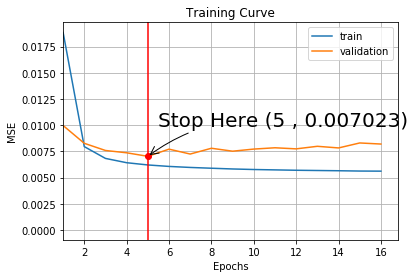


  0%|          | 0/50 [00:00<?, ?it/s]

Training layer 2...
Tensorboard logs dir for this run is /home/xiami/.result/logs/run27



Epoch 01/50:   2%|▏         | 1/50 [00:01<01:13,  1.49s/it]

Epoch 01/50, Train Loss: 0.007497910, Validation Loss: 0.002768058, Best: inf, Wait: 00



Epoch 02/50:   4%|▍         | 2/50 [00:02<01:11,  1.50s/it]

Epoch 02/50, Train Loss: 0.002042689, Validation Loss: 0.001831575, Best: 0.002768058, Wait: 00


Epoch 03/50:   6%|▌         | 3/50 [00:04<01:10,  1.51s/it]

Epoch 03/50, Train Loss: 0.001378786, Validation Loss: 0.001367509, Best: 0.001831575, Wait: 00


Epoch 04/50:   8%|▊         | 4/50 [00:06<01:11,  1.55s/it]

Epoch 04/50, Train Loss: 0.001121295, Validation Loss: 0.001217951, Best: 0.001367509, Wait: 00


Epoch 05/50:  10%|█         | 5/50 [00:07<01:10,  1.57s/it]

Epoch 05/50, Train Loss: 0.000997334, Validation Loss: 0.001137456, Best: 0.001217951, Wait: 00


Epoch 06/50:  12%|█▏        | 6/50 [00:09<01:08,  1.55s/it]

Epoch 06/50, Train Loss: 0.000909230, Validation Loss: 0.001092442, Best: 0.001137456, Wait: 00


Epoch 07/50:  14%|█▍        | 7/50 [00:10<01:05,  1.52s/it]

Epoch 07/50, Train Loss: 0.000844979, Validation Loss: 0.000963283, Best: 0.001092442, Wait: 00


Epoch 08/50:  16%|█▌        | 8/50 [00:12<01:03,  1.52s/it]

Epoch 08/50, Train Loss: 0.000793671, Validation Loss: 0.000973476, Best: 0.000963283, Wait: 00


Epoch 09/50:  18%|█▊        | 9/50 [00:13<01:02,  1.52s/it]

Epoch 09/50, Train Loss: 0.000754061, Validation Loss: 0.000937621, Best: 0.000963283, Wait: 01


Epoch 10/50:  20%|██        | 10/50 [00:15<01:00,  1.52s/it]

Epoch 10/50, Train Loss: 0.000721383, Validation Loss: 0.000897150, Best: 0.000937621, Wait: 00


Epoch 11/50:  22%|██▏       | 11/50 [00:16<00:59,  1.52s/it]

Epoch 11/50, Train Loss: 0.000690522, Validation Loss: 0.000849406, Best: 0.000897150, Wait: 00


Epoch 12/50:  24%|██▍       | 12/50 [00:18<00:58,  1.55s/it]

Epoch 12/50, Train Loss: 0.000665622, Validation Loss: 0.000832238, Best: 0.000849406, Wait: 00


Epoch 13/50:  26%|██▌       | 13/50 [00:19<00:56,  1.53s/it]

Epoch 13/50, Train Loss: 0.000644363, Validation Loss: 0.000819031, Best: 0.000832238, Wait: 00


Epoch 14/50:  28%|██▊       | 14/50 [00:21<00:54,  1.51s/it]

Epoch 14/50, Train Loss: 0.000626811, Validation Loss: 0.000802202, Best: 0.000819031, Wait: 00


Epoch 15/50:  30%|███       | 15/50 [00:22<00:53,  1.52s/it]

Epoch 15/50, Train Loss: 0.000608452, Validation Loss: 0.000793228, Best: 0.000802202, Wait: 00


Epoch 16/50:  32%|███▏      | 16/50 [00:24<00:51,  1.51s/it]

Epoch 16/50, Train Loss: 0.000593950, Validation Loss: 0.000775057, Best: 0.000793228, Wait: 00


Epoch 17/50:  34%|███▍      | 17/50 [00:25<00:49,  1.51s/it]

Epoch 17/50, Train Loss: 0.000581908, Validation Loss: 0.000773712, Best: 0.000775057, Wait: 00


Epoch 18/50:  36%|███▌      | 18/50 [00:27<00:47,  1.48s/it]

Epoch 18/50, Train Loss: 0.000570032, Validation Loss: 0.000782734, Best: 0.000773712, Wait: 00


Epoch 19/50:  38%|███▊      | 19/50 [00:28<00:46,  1.50s/it]

Epoch 19/50, Train Loss: 0.000558793, Validation Loss: 0.000734475, Best: 0.000773712, Wait: 01


Epoch 20/50:  40%|████      | 20/50 [00:30<00:44,  1.48s/it]

Epoch 20/50, Train Loss: 0.000549346, Validation Loss: 0.000746339, Best: 0.000734475, Wait: 00


Epoch 21/50:  42%|████▏     | 21/50 [00:31<00:43,  1.50s/it]

Epoch 21/50, Train Loss: 0.000541622, Validation Loss: 0.000744903, Best: 0.000734475, Wait: 01


Epoch 22/50:  44%|████▍     | 22/50 [00:33<00:41,  1.48s/it]

Epoch 22/50, Train Loss: 0.000534646, Validation Loss: 0.000733657, Best: 0.000734475, Wait: 02


Epoch 23/50:  46%|████▌     | 23/50 [00:34<00:40,  1.49s/it]

Epoch 23/50, Train Loss: 0.000525760, Validation Loss: 0.000733024, Best: 0.000734475, Wait: 03


Epoch 24/50:  48%|████▊     | 24/50 [00:36<00:38,  1.48s/it]

Epoch 24/50, Train Loss: 0.000520385, Validation Loss: 0.000715642, Best: 0.000733024, Wait: 00


Epoch 25/50:  50%|█████     | 25/50 [00:37<00:36,  1.47s/it]

Epoch 25/50, Train Loss: 0.000513842, Validation Loss: 0.000720604, Best: 0.000715642, Wait: 00


Epoch 26/50:  52%|█████▏    | 26/50 [00:39<00:35,  1.47s/it]

Epoch 26/50, Train Loss: 0.000508838, Validation Loss: 0.000724932, Best: 0.000715642, Wait: 01


Epoch 27/50:  54%|█████▍    | 27/50 [00:40<00:33,  1.47s/it]

Epoch 27/50, Train Loss: 0.000503739, Validation Loss: 0.000696340, Best: 0.000715642, Wait: 02


Epoch 28/50:  56%|█████▌    | 28/50 [00:42<00:32,  1.47s/it]

Epoch 28/50, Train Loss: 0.000499070, Validation Loss: 0.000697716, Best: 0.000696340, Wait: 00


Epoch 29/50:  58%|█████▊    | 29/50 [00:43<00:31,  1.48s/it]

Epoch 29/50, Train Loss: 0.000494247, Validation Loss: 0.000681226, Best: 0.000696340, Wait: 01


Epoch 30/50:  60%|██████    | 30/50 [00:45<00:29,  1.48s/it]

Epoch 30/50, Train Loss: 0.000491028, Validation Loss: 0.000705429, Best: 0.000681226, Wait: 00


Epoch 31/50:  62%|██████▏   | 31/50 [00:46<00:28,  1.48s/it]

Epoch 31/50, Train Loss: 0.000486637, Validation Loss: 0.000671601, Best: 0.000681226, Wait: 01


Epoch 32/50:  64%|██████▍   | 32/50 [00:48<00:26,  1.49s/it]

Epoch 32/50, Train Loss: 0.000483593, Validation Loss: 0.000683953, Best: 0.000671601, Wait: 00


Epoch 33/50:  66%|██████▌   | 33/50 [00:49<00:25,  1.47s/it]

Epoch 33/50, Train Loss: 0.000480106, Validation Loss: 0.000675191, Best: 0.000671601, Wait: 01


Epoch 34/50:  68%|██████▊   | 34/50 [00:51<00:23,  1.47s/it]

Epoch 34/50, Train Loss: 0.000476601, Validation Loss: 0.000669834, Best: 0.000671601, Wait: 02


Epoch 35/50:  70%|███████   | 35/50 [00:52<00:22,  1.48s/it]

Epoch 35/50, Train Loss: 0.000474335, Validation Loss: 0.000691185, Best: 0.000669834, Wait: 00


Epoch 36/50:  72%|███████▏  | 36/50 [00:54<00:21,  1.51s/it]

Epoch 36/50, Train Loss: 0.000473129, Validation Loss: 0.000673250, Best: 0.000669834, Wait: 01


Epoch 37/50:  74%|███████▍  | 37/50 [00:55<00:19,  1.49s/it]

Epoch 37/50, Train Loss: 0.000469369, Validation Loss: 0.000688873, Best: 0.000669834, Wait: 02


Epoch 38/50:  76%|███████▌  | 38/50 [00:57<00:17,  1.49s/it]

Epoch 38/50, Train Loss: 0.000466505, Validation Loss: 0.000675325, Best: 0.000669834, Wait: 03


Epoch 39/50:  78%|███████▊  | 39/50 [00:58<00:16,  1.49s/it]

Epoch 39/50, Train Loss: 0.000464487, Validation Loss: 0.000667955, Best: 0.000669834, Wait: 04


Epoch 40/50:  80%|████████  | 40/50 [01:00<00:14,  1.48s/it]

Epoch 40/50, Train Loss: 0.000463362, Validation Loss: 0.000660095, Best: 0.000667955, Wait: 00


Epoch 41/50:  82%|████████▏ | 41/50 [01:01<00:13,  1.48s/it]

Epoch 41/50, Train Loss: 0.000461150, Validation Loss: 0.000675574, Best: 0.000660095, Wait: 00


Epoch 42/50:  84%|████████▍ | 42/50 [01:02<00:11,  1.48s/it]

Epoch 42/50, Train Loss: 0.000460108, Validation Loss: 0.000660927, Best: 0.000660095, Wait: 01


Epoch 43/50:  86%|████████▌ | 43/50 [01:04<00:10,  1.48s/it]

Epoch 43/50, Train Loss: 0.000456971, Validation Loss: 0.000659341, Best: 0.000660095, Wait: 02


Epoch 44/50:  88%|████████▊ | 44/50 [01:05<00:08,  1.47s/it]

Epoch 44/50, Train Loss: 0.000456306, Validation Loss: 0.000669884, Best: 0.000660095, Wait: 03


Epoch 45/50:  90%|█████████ | 45/50 [01:07<00:07,  1.48s/it]

Epoch 45/50, Train Loss: 0.000454354, Validation Loss: 0.000644586, Best: 0.000660095, Wait: 04


Epoch 46/50:  92%|█████████▏| 46/50 [01:08<00:05,  1.47s/it]

Epoch 46/50, Train Loss: 0.000452289, Validation Loss: 0.000658459, Best: 0.000644586, Wait: 00


Epoch 47/50:  94%|█████████▍| 47/50 [01:10<00:04,  1.49s/it]

Epoch 47/50, Train Loss: 0.000451085, Validation Loss: 0.000636800, Best: 0.000644586, Wait: 01


Epoch 48/50:  96%|█████████▌| 48/50 [01:11<00:03,  1.51s/it]

Epoch 48/50, Train Loss: 0.000449936, Validation Loss: 0.000632741, Best: 0.000636800, Wait: 00


Epoch 49/50:  98%|█████████▊| 49/50 [01:13<00:01,  1.52s/it]

Epoch 49/50, Train Loss: 0.000448110, Validation Loss: 0.000644454, Best: 0.000632741, Wait: 00


Epoch 50/50: 100%|██████████| 50/50 [01:15<00:00,  1.54s/it]

Epoch 50/50, Train Loss: 0.000447705, Validation Loss: 0.000653159, Best: 0.000632741, Wait: 01
Epoch 00048: early stopping


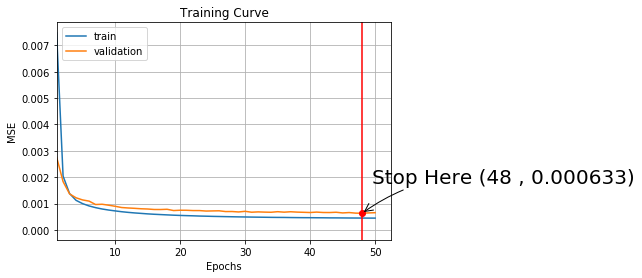

Training layer 3...
Tensorboard logs dir for this run is /home/xiami/.result/logs/run28


Epoch 01/50:   2%|▏         | 1/50 [00:01<01:00,  1.24s/it]

Epoch 01/50, Train Loss: 0.006298547, Validation Loss: 0.002455717, Best: inf, Wait: 00


Epoch 02/50:   4%|▍         | 2/50 [00:02<00:59,  1.23s/it]

Epoch 02/50, Train Loss: 0.002007202, Validation Loss: 0.001932977, Best: 0.002455717, Wait: 00


Epoch 03/50:   6%|▌         | 3/50 [00:03<00:58,  1.25s/it]

Epoch 03/50, Train Loss: 0.001683499, Validation Loss: 0.001715156, Best: 0.001932977, Wait: 00


Epoch 04/50:   8%|▊         | 4/50 [00:05<00:57,  1.25s/it]

Epoch 04/50, Train Loss: 0.001527323, Validation Loss: 0.001572548, Best: 0.001715156, Wait: 00


Epoch 05/50:  10%|█         | 5/50 [00:06<00:55,  1.24s/it]

Epoch 05/50, Train Loss: 0.001438710, Validation Loss: 0.001516317, Best: 0.001572548, Wait: 00


Epoch 06/50:  12%|█▏        | 6/50 [00:07<00:55,  1.26s/it]

Epoch 06/50, Train Loss: 0.001371657, Validation Loss: 0.001432407, Best: 0.001516317, Wait: 00


Epoch 07/50:  14%|█▍        | 7/50 [00:08<00:54,  1.28s/it]

Epoch 07/50, Train Loss: 0.001320611, Validation Loss: 0.001424430, Best: 0.001432407, Wait: 00


Epoch 08/50:  16%|█▌        | 8/50 [00:10<00:54,  1.29s/it]

Epoch 08/50, Train Loss: 0.001273943, Validation Loss: 0.001340518, Best: 0.001424430, Wait: 00


Epoch 09/50:  18%|█▊        | 9/50 [00:11<00:53,  1.30s/it]

Epoch 09/50, Train Loss: 0.001238135, Validation Loss: 0.001277609, Best: 0.001340518, Wait: 00


Epoch 10/50:  20%|██        | 10/50 [00:12<00:51,  1.28s/it]

Epoch 10/50, Train Loss: 0.001206024, Validation Loss: 0.001269850, Best: 0.001277609, Wait: 00


Epoch 11/50:  22%|██▏       | 11/50 [00:13<00:48,  1.25s/it]

Epoch 11/50, Train Loss: 0.001174181, Validation Loss: 0.001283739, Best: 0.001269850, Wait: 00


Epoch 12/50:  24%|██▍       | 12/50 [00:15<00:47,  1.25s/it]

Epoch 12/50, Train Loss: 0.001151797, Validation Loss: 0.001235072, Best: 0.001269850, Wait: 01


Epoch 13/50:  26%|██▌       | 13/50 [00:16<00:45,  1.23s/it]

Epoch 13/50, Train Loss: 0.001128228, Validation Loss: 0.001242720, Best: 0.001235072, Wait: 00


Epoch 14/50:  28%|██▊       | 14/50 [00:17<00:44,  1.22s/it]

Epoch 14/50, Train Loss: 0.001106051, Validation Loss: 0.001235198, Best: 0.001235072, Wait: 01


Epoch 15/50:  30%|███       | 15/50 [00:18<00:43,  1.24s/it]

Epoch 15/50, Train Loss: 0.001087768, Validation Loss: 0.001186841, Best: 0.001235072, Wait: 02


Epoch 16/50:  32%|███▏      | 16/50 [00:20<00:42,  1.26s/it]

Epoch 16/50, Train Loss: 0.001066709, Validation Loss: 0.001159948, Best: 0.001186841, Wait: 00


Epoch 17/50:  34%|███▍      | 17/50 [00:21<00:40,  1.24s/it]

Epoch 17/50, Train Loss: 0.001052424, Validation Loss: 0.001178350, Best: 0.001159948, Wait: 00


Epoch 18/50:  36%|███▌      | 18/50 [00:22<00:39,  1.24s/it]

Epoch 18/50, Train Loss: 0.001035158, Validation Loss: 0.001131767, Best: 0.001159948, Wait: 01


Epoch 19/50:  38%|███▊      | 19/50 [00:23<00:38,  1.24s/it]

Epoch 19/50, Train Loss: 0.001021793, Validation Loss: 0.001136404, Best: 0.001131767, Wait: 00


Epoch 20/50:  40%|████      | 20/50 [00:24<00:36,  1.23s/it]

Epoch 20/50, Train Loss: 0.001005752, Validation Loss: 0.001095512, Best: 0.001131767, Wait: 01


Epoch 21/50:  42%|████▏     | 21/50 [00:26<00:35,  1.23s/it]

Epoch 21/50, Train Loss: 0.000992835, Validation Loss: 0.001051917, Best: 0.001095512, Wait: 00


Epoch 22/50:  44%|████▍     | 22/50 [00:27<00:34,  1.24s/it]

Epoch 22/50, Train Loss: 0.000980370, Validation Loss: 0.001092516, Best: 0.001051917, Wait: 00


Epoch 23/50:  46%|████▌     | 23/50 [00:28<00:33,  1.24s/it]

Epoch 23/50, Train Loss: 0.000968979, Validation Loss: 0.001075777, Best: 0.001051917, Wait: 01


Epoch 24/50:  48%|████▊     | 24/50 [00:30<00:32,  1.27s/it]

Epoch 24/50, Train Loss: 0.000957244, Validation Loss: 0.001019709, Best: 0.001051917, Wait: 02


Epoch 25/50:  50%|█████     | 25/50 [00:31<00:31,  1.28s/it]

Epoch 25/50, Train Loss: 0.000945636, Validation Loss: 0.001032521, Best: 0.001019709, Wait: 00


Epoch 26/50:  52%|█████▏    | 26/50 [00:32<00:30,  1.27s/it]

Epoch 26/50, Train Loss: 0.000932838, Validation Loss: 0.001024729, Best: 0.001019709, Wait: 01


Epoch 27/50:  54%|█████▍    | 27/50 [00:33<00:29,  1.27s/it]

Epoch 27/50, Train Loss: 0.000923948, Validation Loss: 0.000990714, Best: 0.001019709, Wait: 02


Epoch 28/50:  56%|█████▌    | 28/50 [00:35<00:27,  1.26s/it]

Epoch 28/50, Train Loss: 0.000915369, Validation Loss: 0.001028802, Best: 0.000990714, Wait: 00


Epoch 29/50:  58%|█████▊    | 29/50 [00:36<00:26,  1.26s/it]

Epoch 29/50, Train Loss: 0.000907878, Validation Loss: 0.000987110, Best: 0.000990714, Wait: 01


Epoch 30/50:  60%|██████    | 30/50 [00:37<00:24,  1.23s/it]

Epoch 30/50, Train Loss: 0.000897866, Validation Loss: 0.000999675, Best: 0.000987110, Wait: 00


Epoch 31/50:  62%|██████▏   | 31/50 [00:38<00:23,  1.22s/it]

Epoch 31/50, Train Loss: 0.000890965, Validation Loss: 0.000998334, Best: 0.000987110, Wait: 01


Epoch 32/50:  64%|██████▍   | 32/50 [00:39<00:22,  1.23s/it]

Epoch 32/50, Train Loss: 0.000880728, Validation Loss: 0.001000773, Best: 0.000987110, Wait: 02


Epoch 33/50:  66%|██████▌   | 33/50 [00:41<00:20,  1.23s/it]

Epoch 33/50, Train Loss: 0.000872473, Validation Loss: 0.001012878, Best: 0.000987110, Wait: 03


Epoch 34/50:  68%|██████▊   | 34/50 [00:42<00:19,  1.24s/it]

Epoch 34/50, Train Loss: 0.000864175, Validation Loss: 0.000959215, Best: 0.000987110, Wait: 04


Epoch 35/50:  70%|███████   | 35/50 [00:43<00:18,  1.25s/it]

Epoch 35/50, Train Loss: 0.000858215, Validation Loss: 0.000932456, Best: 0.000959215, Wait: 00


Epoch 36/50:  72%|███████▏  | 36/50 [00:45<00:17,  1.26s/it]

Epoch 36/50, Train Loss: 0.000849425, Validation Loss: 0.000943199, Best: 0.000932456, Wait: 00


Epoch 37/50:  74%|███████▍  | 37/50 [00:46<00:16,  1.27s/it]

Epoch 37/50, Train Loss: 0.000844074, Validation Loss: 0.000929256, Best: 0.000932456, Wait: 01


Epoch 38/50:  76%|███████▌  | 38/50 [00:47<00:15,  1.28s/it]

Epoch 38/50, Train Loss: 0.000836867, Validation Loss: 0.000936735, Best: 0.000929256, Wait: 00


Epoch 39/50:  78%|███████▊  | 39/50 [00:48<00:14,  1.29s/it]

Epoch 39/50, Train Loss: 0.000830472, Validation Loss: 0.000919193, Best: 0.000929256, Wait: 01


Epoch 40/50:  80%|████████  | 40/50 [00:50<00:12,  1.30s/it]

Epoch 40/50, Train Loss: 0.000824452, Validation Loss: 0.000907377, Best: 0.000919193, Wait: 00


Epoch 41/50:  82%|████████▏ | 41/50 [00:51<00:11,  1.30s/it]

Epoch 41/50, Train Loss: 0.000817568, Validation Loss: 0.000903504, Best: 0.000907377, Wait: 00


Epoch 42/50:  84%|████████▍ | 42/50 [00:52<00:10,  1.27s/it]

Epoch 42/50, Train Loss: 0.000811280, Validation Loss: 0.000902679, Best: 0.000903504, Wait: 00


Epoch 43/50:  86%|████████▌ | 43/50 [00:54<00:08,  1.26s/it]

Epoch 43/50, Train Loss: 0.000805884, Validation Loss: 0.000899641, Best: 0.000903504, Wait: 01


Epoch 44/50:  88%|████████▊ | 44/50 [00:55<00:07,  1.23s/it]

Epoch 44/50, Train Loss: 0.000799408, Validation Loss: 0.000930532, Best: 0.000899641, Wait: 00


Epoch 45/50:  90%|█████████ | 45/50 [00:56<00:06,  1.24s/it]

Epoch 45/50, Train Loss: 0.000794875, Validation Loss: 0.000884447, Best: 0.000899641, Wait: 01


Epoch 46/50:  92%|█████████▏| 46/50 [00:57<00:04,  1.24s/it]

Epoch 46/50, Train Loss: 0.000788815, Validation Loss: 0.000874296, Best: 0.000884447, Wait: 00


Epoch 47/50:  94%|█████████▍| 47/50 [00:58<00:03,  1.26s/it]

Epoch 47/50, Train Loss: 0.000783248, Validation Loss: 0.000870031, Best: 0.000874296, Wait: 00


Epoch 48/50:  96%|█████████▌| 48/50 [01:00<00:02,  1.24s/it]

Epoch 48/50, Train Loss: 0.000778425, Validation Loss: 0.000884953, Best: 0.000870031, Wait: 00


Epoch 49/50:  98%|█████████▊| 49/50 [01:01<00:01,  1.25s/it]

Epoch 49/50, Train Loss: 0.000774602, Validation Loss: 0.000869414, Best: 0.000870031, Wait: 01


Epoch 50/50: 100%|██████████| 50/50 [01:02<00:00,  1.27s/it]

Epoch 50/50, Train Loss: 0.000769387, Validation Loss: 0.000864262, Best: 0.000870031, Wait: 02
Epoch 00050: early stopping


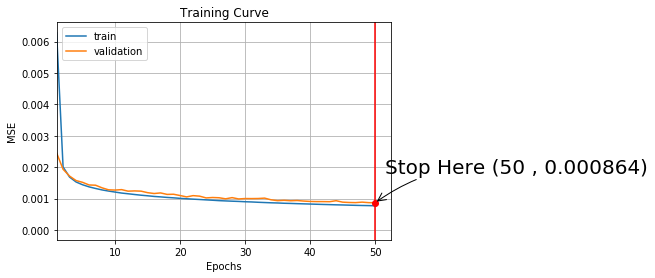

Training layer 4...


  0%|          | 0/50 [00:00<?, ?it/s]

Tensorboard logs dir for this run is /home/xiami/.result/logs/run29


Epoch 01/50:   2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

Epoch 01/50, Train Loss: 0.039580792, Validation Loss: 0.023730725, Best: inf, Wait: 00


Epoch 02/50:   4%|▍         | 2/50 [00:02<00:51,  1.08s/it]

Epoch 02/50, Train Loss: 0.022983508, Validation Loss: 0.022274574, Best: 0.023730725, Wait: 00


Epoch 03/50:   6%|▌         | 3/50 [00:03<00:51,  1.09s/it]

Epoch 03/50, Train Loss: 0.022208316, Validation Loss: 0.021879321, Best: 0.022274574, Wait: 00


Epoch 04/50:   8%|▊         | 4/50 [00:04<00:49,  1.07s/it]

Epoch 04/50, Train Loss: 0.021899061, Validation Loss: 0.021641407, Best: 0.021879321, Wait: 00


Epoch 05/50:  10%|█         | 5/50 [00:05<00:47,  1.06s/it]

Epoch 05/50, Train Loss: 0.021691456, Validation Loss: 0.021463478, Best: 0.021641407, Wait: 00


Epoch 06/50:  12%|█▏        | 6/50 [00:06<00:46,  1.05s/it]

Epoch 06/50, Train Loss: 0.021533703, Validation Loss: 0.021281788, Best: 0.021463478, Wait: 00


Epoch 07/50:  14%|█▍        | 7/50 [00:07<00:45,  1.07s/it]

Epoch 07/50, Train Loss: 0.021387319, Validation Loss: 0.021161854, Best: 0.021281788, Wait: 00


Epoch 08/50:  16%|█▌        | 8/50 [00:08<00:44,  1.06s/it]

Epoch 08/50, Train Loss: 0.021257159, Validation Loss: 0.021055171, Best: 0.021161854, Wait: 00


Epoch 09/50:  18%|█▊        | 9/50 [00:09<00:43,  1.06s/it]

Epoch 09/50, Train Loss: 0.021155353, Validation Loss: 0.020937778, Best: 0.021055171, Wait: 00


Epoch 10/50:  20%|██        | 10/50 [00:10<00:42,  1.06s/it]

Epoch 10/50, Train Loss: 0.021070749, Validation Loss: 0.020839330, Best: 0.020937778, Wait: 00


Epoch 11/50:  22%|██▏       | 11/50 [00:11<00:40,  1.05s/it]

Epoch 11/50, Train Loss: 0.020994219, Validation Loss: 0.020779571, Best: 0.020839330, Wait: 00


Epoch 12/50:  24%|██▍       | 12/50 [00:12<00:39,  1.05s/it]

Epoch 12/50, Train Loss: 0.020930827, Validation Loss: 0.020741962, Best: 0.020779571, Wait: 00


Epoch 13/50:  26%|██▌       | 13/50 [00:13<00:38,  1.04s/it]

Epoch 13/50, Train Loss: 0.020883039, Validation Loss: 0.020689216, Best: 0.020741962, Wait: 00


Epoch 14/50:  28%|██▊       | 14/50 [00:14<00:37,  1.04s/it]

Epoch 14/50, Train Loss: 0.020840642, Validation Loss: 0.020639086, Best: 0.020689216, Wait: 00


Epoch 15/50:  30%|███       | 15/50 [00:15<00:36,  1.05s/it]

Epoch 15/50, Train Loss: 0.020805461, Validation Loss: 0.020614048, Best: 0.020639086, Wait: 00


Epoch 16/50:  32%|███▏      | 16/50 [00:16<00:35,  1.06s/it]

Epoch 16/50, Train Loss: 0.020775736, Validation Loss: 0.020581080, Best: 0.020614048, Wait: 00


Epoch 17/50:  34%|███▍      | 17/50 [00:17<00:34,  1.05s/it]

Epoch 17/50, Train Loss: 0.020750033, Validation Loss: 0.020595580, Best: 0.020581080, Wait: 00


Epoch 18/50:  36%|███▌      | 18/50 [00:19<00:34,  1.06s/it]

Epoch 18/50, Train Loss: 0.020722102, Validation Loss: 0.020559687, Best: 0.020581080, Wait: 01


Epoch 19/50:  38%|███▊      | 19/50 [00:20<00:33,  1.07s/it]

Epoch 19/50, Train Loss: 0.020699893, Validation Loss: 0.020558633, Best: 0.020559687, Wait: 00


Epoch 20/50:  40%|████      | 20/50 [00:21<00:32,  1.07s/it]

Epoch 20/50, Train Loss: 0.020672325, Validation Loss: 0.020479338, Best: 0.020558633, Wait: 00


Epoch 21/50:  42%|████▏     | 21/50 [00:22<00:31,  1.07s/it]

Epoch 21/50, Train Loss: 0.020651641, Validation Loss: 0.020487636, Best: 0.020479338, Wait: 00


Epoch 22/50:  44%|████▍     | 22/50 [00:23<00:29,  1.06s/it]

Epoch 22/50, Train Loss: 0.020638381, Validation Loss: 0.020478094, Best: 0.020479338, Wait: 01


Epoch 23/50:  46%|████▌     | 23/50 [00:24<00:28,  1.05s/it]

Epoch 23/50, Train Loss: 0.020618633, Validation Loss: 0.020454613, Best: 0.020478094, Wait: 00


Epoch 24/50:  48%|████▊     | 24/50 [00:25<00:27,  1.04s/it]

Epoch 24/50, Train Loss: 0.020609054, Validation Loss: 0.020431384, Best: 0.020454613, Wait: 00


Epoch 25/50:  50%|█████     | 25/50 [00:26<00:25,  1.03s/it]

Epoch 25/50, Train Loss: 0.020595021, Validation Loss: 0.020435186, Best: 0.020431384, Wait: 00


Epoch 26/50:  52%|█████▏    | 26/50 [00:27<00:24,  1.04s/it]

Epoch 26/50, Train Loss: 0.020581828, Validation Loss: 0.020436157, Best: 0.020431384, Wait: 01


Epoch 27/50:  54%|█████▍    | 27/50 [00:28<00:23,  1.04s/it]

Epoch 27/50, Train Loss: 0.020571161, Validation Loss: 0.020407742, Best: 0.020431384, Wait: 02


Epoch 28/50:  56%|█████▌    | 28/50 [00:29<00:22,  1.04s/it]

Epoch 28/50, Train Loss: 0.020556178, Validation Loss: 0.020350765, Best: 0.020407742, Wait: 00


Epoch 29/50:  58%|█████▊    | 29/50 [00:30<00:21,  1.05s/it]

Epoch 29/50, Train Loss: 0.020542806, Validation Loss: 0.020360218, Best: 0.020350765, Wait: 00


Epoch 30/50:  60%|██████    | 30/50 [00:31<00:21,  1.06s/it]

Epoch 30/50, Train Loss: 0.020528444, Validation Loss: 0.020361997, Best: 0.020350765, Wait: 01


Epoch 31/50:  62%|██████▏   | 31/50 [00:32<00:19,  1.03s/it]

Epoch 31/50, Train Loss: 0.020507502, Validation Loss: 0.020382227, Best: 0.020350765, Wait: 02


Epoch 32/50:  64%|██████▍   | 32/50 [00:33<00:18,  1.05s/it]

Epoch 32/50, Train Loss: 0.020493402, Validation Loss: 0.020291867, Best: 0.020350765, Wait: 03


Epoch 33/50:  66%|██████▌   | 33/50 [00:34<00:17,  1.05s/it]

Epoch 33/50, Train Loss: 0.020487689, Validation Loss: 0.020305321, Best: 0.020291867, Wait: 00


Epoch 34/50:  68%|██████▊   | 34/50 [00:35<00:17,  1.08s/it]

Epoch 34/50, Train Loss: 0.020477131, Validation Loss: 0.020310028, Best: 0.020291867, Wait: 01


Epoch 35/50:  70%|███████   | 35/50 [00:37<00:16,  1.09s/it]

Epoch 35/50, Train Loss: 0.020471138, Validation Loss: 0.020310186, Best: 0.020291867, Wait: 02


Epoch 36/50:  72%|███████▏  | 36/50 [00:38<00:15,  1.09s/it]

Epoch 36/50, Train Loss: 0.020467323, Validation Loss: 0.020288734, Best: 0.020291867, Wait: 03


Epoch 37/50:  74%|███████▍  | 37/50 [00:39<00:14,  1.11s/it]

Epoch 37/50, Train Loss: 0.020457504, Validation Loss: 0.020275498, Best: 0.020288734, Wait: 00


Epoch 38/50:  76%|███████▌  | 38/50 [00:40<00:13,  1.11s/it]

Epoch 38/50, Train Loss: 0.020450859, Validation Loss: 0.020290935, Best: 0.020275498, Wait: 00


Epoch 39/50:  78%|███████▊  | 39/50 [00:41<00:12,  1.11s/it]

Epoch 39/50, Train Loss: 0.020443525, Validation Loss: 0.020272203, Best: 0.020275498, Wait: 01


Epoch 40/50:  80%|████████  | 40/50 [00:42<00:11,  1.11s/it]

Epoch 40/50, Train Loss: 0.020434599, Validation Loss: 0.020276686, Best: 0.020272203, Wait: 00


Epoch 41/50:  82%|████████▏ | 41/50 [00:43<00:09,  1.11s/it]

Epoch 41/50, Train Loss: 0.020431380, Validation Loss: 0.020251157, Best: 0.020272203, Wait: 01


Epoch 42/50:  84%|████████▍ | 42/50 [00:44<00:08,  1.10s/it]

Epoch 42/50, Train Loss: 0.020423360, Validation Loss: 0.020237138, Best: 0.020251157, Wait: 00


Epoch 43/50:  86%|████████▌ | 43/50 [00:45<00:07,  1.09s/it]

Epoch 43/50, Train Loss: 0.020420877, Validation Loss: 0.020212308, Best: 0.020237138, Wait: 00


Epoch 44/50:  88%|████████▊ | 44/50 [00:46<00:06,  1.07s/it]

Epoch 44/50, Train Loss: 0.020415944, Validation Loss: 0.020242935, Best: 0.020212308, Wait: 00


Epoch 45/50:  90%|█████████ | 45/50 [00:48<00:05,  1.08s/it]

Epoch 45/50, Train Loss: 0.020412350, Validation Loss: 0.020213878, Best: 0.020212308, Wait: 01


Epoch 46/50:  92%|█████████▏| 46/50 [00:49<00:04,  1.09s/it]

Epoch 46/50, Train Loss: 0.020411709, Validation Loss: 0.020239798, Best: 0.020212308, Wait: 02


Epoch 47/50:  94%|█████████▍| 47/50 [00:50<00:03,  1.07s/it]

Epoch 47/50, Train Loss: 0.020408943, Validation Loss: 0.020233184, Best: 0.020212308, Wait: 03


Epoch 48/50:  96%|█████████▌| 48/50 [00:51<00:02,  1.05s/it]

Epoch 48/50, Train Loss: 0.020407778, Validation Loss: 0.020223159, Best: 0.020212308, Wait: 04


Epoch 49/50:  98%|█████████▊| 49/50 [00:52<00:01,  1.05s/it]

Epoch 49/50, Train Loss: 0.020405147, Validation Loss: 0.020218700, Best: 0.020212308, Wait: 05


Epoch 50/50: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

Epoch 50/50, Train Loss: 0.020402636, Validation Loss: 0.020234061, Best: 0.020212308, Wait: 06
Epoch 00043: early stopping


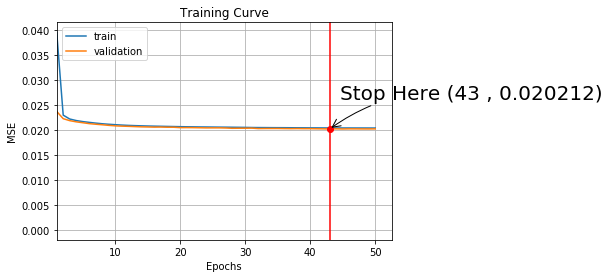

Tensorboard logs dir for this run is /home/xiami/.result/logs/run30


Accuracy: 0.966: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Test set accuracy: 0.9614001512527466


In [9]:
if __name__== '__main__':
  
   seed = -1
   utilities.random_seed_np_tf(seed)
   
   mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)
   trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

   vlX = mnist.validation.images
   vlY = mnist.validation.labels


   sdae = StackedDenoisingAutoencoder()
   
   # Fit the model (unsupervised pretraining)
   encoded_X, encoded_vX = sdae.pretrain(trX, vlX)

   # Supervised finetuning
   sdae.fit(trX, trY, vlX, vlY)

   # Compute the accuracy of the model
   print('Test set accuracy: {}'.format(sdae.score(teX, teY)))

 